In [ ]:
### In the previous instance, we have seen the agent captures 5 rounds of samples for experience in
### one epoch.

### To speed up the processes, we can create multiple environment, each agent works in each environment
### So, we can parallely, gather experience. This will significantly speed up the process. 

In [ ]:
### Using the above procedure, either we can calculate the gradients for each environment seperately,
### This way all the agents in different environments update tne weights of the main model
### asynchronously, This is called asynchronous advantage actor critic. (A3C)

In [ ]:
### The algotithm is given as:

In [1]:
import matplotlib.pyplot as plt
import cv2

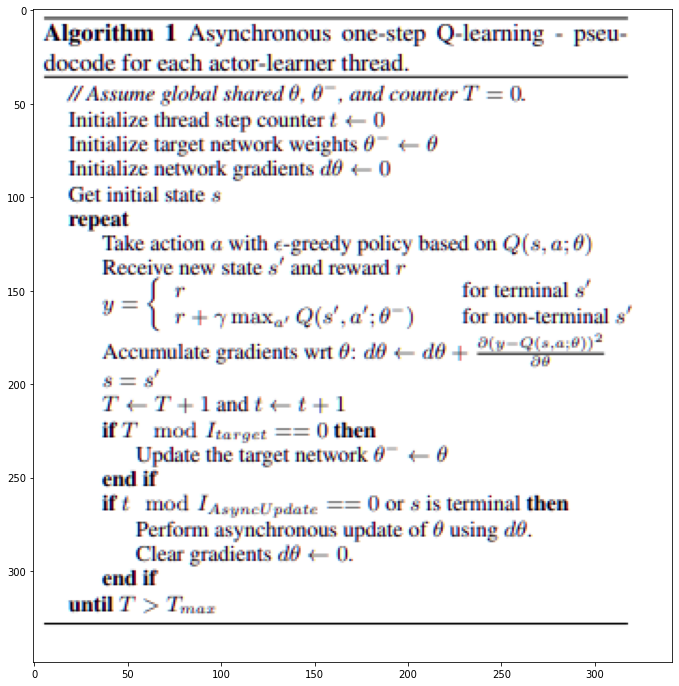

In [3]:
img=cv2.imread("A3C.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [ ]:
### Outlined as:

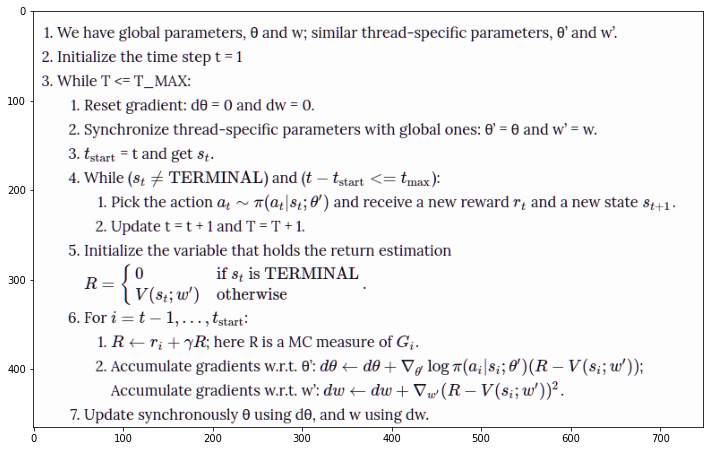

In [4]:
img=cv2.imread("Outline.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [5]:
### Now, for every environment, we initialize and update asynchronously, this creates a problem 
### as all the environments might not use the updated policy. This creates some problems
### as A3C is an on-policy algorithm.

### On-policy algorithms are those which algorithms can only work on current samples directly from the
### environment dependent on the current policy. So, no experience buffer can be used. Sample efficiency 
### is low.

### The off-policy algorithms are those which can operate using replay buffers. So, the previous samples 
### can also be used for the update. Sample efficiency is more.

In [ ]:
### To solve the problem A2C or Advantage Actor Critic was introduced, which worked on the agents
### in an multi environment setting, but the update was synchronous. So, the update was only done
### after all the agents in all the environments gather their experiences. 

### So, every thing is done perfectly parallel, and global parameters are synchronisedly updated.

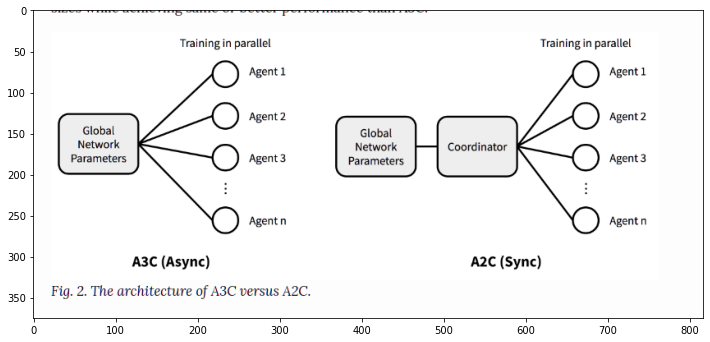

In [6]:
img=cv2.imread("Comparison.png")
plt.figure(figsize=(12,12))
plt.imshow(img)

plt.show()

In [7]:
### A2C is organised with a coordinator.

In [ ]:
### The problem of multi-environment can be solved using stable_baselines libraries.

### CartPole Problem

In [ ]:
#### Installing stable_baselines for tensorflow 2.x. Its still experimental

In [ ]:
!git clone https://github.com/Stable-Baselines-Team/stable-baselines-tf2.git

In [ ]:
!pip install ./stable-baselines-tf2

#### Solution

In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from stable_baselines.common.vec_env import SubprocVecEnv  ### Subprocess environment


In [16]:
class A2C_with_multi_env:

  def __init__(self,env,env_name,num_of_env):
    self.state_dimension=env.observation_space.shape   ### Input state dimension
    self.no_of_action=env.action_space.n               ### No of actions
    self.no_of_env=num_of_env
    self.Actor=None      ### the learner
    self.Critic=None     ### Critic
    self.env=SubprocVecEnv([self.create_env(env_name,i) for i in range(self.no_of_env)])
    self.opt=tf.keras.optimizers.RMSprop(lr=0.0003)
    self.steps_in_epi=256    ### Fixed number of steps in a episode
    self.epochs=5000         ### Number of epochs

  def create_env(self,env_id,rank,seed=101):
    def get_env():         #### The seed lets generate same sequence, and starting state is same and
    ### every time performance is same
      env=gym.make(env_id)
      env.seed(seed+rank)
      return env
    return get_env
  ### Creates the multiple environments

  def get_actor(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(self.no_of_action, activation="softmax")(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate a probabilistic distribution so softmax is used as the activation function.
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model
  
  def get_critic(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the estimate value function V(s)

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the Value function for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model

  def loss_actor(self,S,A,Adv):

    log_pi_A_given_S=self.log_prob(S,A) 
    actor_loss= -1*tf.reduce_mean(tf.multiply(log_pi_A_given_S,Adv))
    return actor_loss
    ### Loss for actor L= - mean(log(P(a|s : w)).A(s,a))

  def loss_critic(self,S,Targets):
    return 0.5*tf.reduce_mean(tf.math.squared_difference(Targets,self.Critic(S)))
    ### Loss for critic L = mean(|R(lambda) - V(s)|^2)
  
  def entropy(self,S):
    logits=self.Actor(S)
    dist=tfp.distributions.Categorical(logits=logits)
    return tf.reduce_mean(dist.entropy())
    ### Entropy induces exploration.
  
  def action(self,s):

    out=self.Actor(s)   
    action_prob=tfp.distributions.Categorical(probs=out)
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the action
    return action.numpy()  ### Action returned as 1D tensor-> converting to scalar

  def log_prob(self,s,a):

    out=self.Actor(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Categorical(probs=out)
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    
    return action_prob.log_prob(a)
  
  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]
    next_states=[]
    not_done=[]
    

    curr_state=self.env.reset()
    for _ in range(self.steps_in_epi):
      ### Recording fixed number of steps.
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append(reward)
      next_states.append(next_state)
      not_done.append(1-done)

      #### actions is in the form [[1,2,3,4],[1,2,3,4]..........]
      ### One for each environment on each step.

      ### Each of the variables are in the same form.

      ### Returns a stacked array of size equal to no. of environments.

      ### Automatically resets environment when done.
      
      ### logging the essential required values for loss estimation
  
      curr_state=next_state ### Updating.

    return np.array(states),np.array(actions),np.array(rewards),np.array(next_states),np.array(not_done)  ### All logs returned

  def get_value_funcs(self,states,next_states):
    
    values=self.Critic.predict(states)   ### Recording the values for the states 

    ### Takes in [[[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]],[[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2,3,4]].....]
    ### On each step, there are 4 states, from 4 environments, each environment is of the size dimension 4 (for this env).

    ### The Critic model produces output [[[1],[2],[3],[4]],[[1],[2],[3],[4]]..........]
    ### So, for states of dimension [n x 4 x 4] output is  [n x 4 x 1]
    ### So, we reshape to maintain shape similar to actions and rewards.

    values=values.reshape((len(values),self.no_of_env))
    next_values=self.Critic.predict(next_states)   ### Recording the values for the next states
    next_values=next_values.reshape((len(values),self.no_of_env))
    return values,next_values

  def get_gae(self,next_values,values,rewards,not_dones,gamma=0.99,lam=0.95):
    
    gae=0
    returns=[]
    ### Calculating GAE according to formulation.

    #### This setting is necessary, as we need element wise multiplication
    ### So that we can multiply the values for the correct environment.
    ### If we flatten before this, the returns for one environment will mix with other and 
    ### so will give a wrong estimate.
    for step in reversed(range(len(rewards))):
      TD_error_delta = rewards[step] + gamma * next_values[step] * not_dones[step] - values[step]
      gae = TD_error_delta + gamma * lam * not_dones[step] * gae
      ret = gae + values[step]
      returns.insert(0,ret)
    
    return np.array(returns)
  
  def test_play(self):
    ### Testing results for current weights.
    overall=0
    for _ in range(5):
      curr_states=self.env.reset()
      curr_state=curr_states[0]
      total_reward=0
      done=[False]*self.no_of_env
      while not done[0]:
        a=self.action(curr_state.reshape(1,-1))
        next_state,reward,done,_=(self.env.step([a[0],0,0,0]))
        total_reward+=reward[0]
        curr_state=next_state[0]
      overall+=total_reward
    return overall/5
  
  def train(self):
    ### Training
    self.Actor=self.get_actor()
    self.Critic=self.get_critic()

    for i in range(self.epochs):

      ### For each epoch
      s,a,R,Ns,Nd=self.get_episodes()

      v,next_vals=self.get_value_funcs(s,Ns)
      
      r=self.get_gae(next_vals,v,R,Nd)

      s=s.reshape((len(s)*self.no_of_env,self.state_dimension[0]))
      a=a.reshape((len(a)*self.no_of_env,))
      v=v.reshape((len(v)*self.no_of_env,))
      r=r.reshape((len(r)*self.no_of_env,))

      ### Before training we flatten the arrays. (256,4) -> (1024,)

      #print(np.array(s).shape)
      #### Obtaining values
      adv= r - v
      #### Calculating advantages

      adv = (adv - adv.mean())/adv.std()
      ### Normalizing the advantages

      with tf.GradientTape() as t:
        act_loss=self.loss_actor(s,a,adv)
        crit_loss=self.loss_critic(s,r)
        loss=act_loss+0.25*crit_loss-0.01*self.entropy(s)
      ### Calculating loss
      grads=t.gradient(loss,self.Actor.trainable_variables+self.Critic.trainable_variables)
      self.opt.apply_gradients(zip(grads,self.Actor.trainable_variables+self.Critic.trainable_variables))
      #### Applying gradients.
    
      if i%10==0:
        score=self.test_play()
        print(f"On Iteration {i} scores: {score}")

In [ ]:
agent=A2C_with_multi_env(env,'CartPole-v0',4)

In [ ]:
agent.train()

On Iteration 0 scores: 17.0
On Iteration 10 scores: 25.4
On Iteration 20 scores: 50.8
On Iteration 30 scores: 53.0
On Iteration 40 scores: 84.2
On Iteration 50 scores: 96.4
On Iteration 60 scores: 139.4
On Iteration 70 scores: 161.4
On Iteration 80 scores: 159.6
On Iteration 90 scores: 102.0
On Iteration 100 scores: 172.8
On Iteration 110 scores: 130.4
On Iteration 120 scores: 146.4
On Iteration 130 scores: 168.4
On Iteration 140 scores: 139.8
On Iteration 150 scores: 173.0
On Iteration 160 scores: 177.8
On Iteration 170 scores: 143.4
On Iteration 180 scores: 152.6
On Iteration 190 scores: 154.6
On Iteration 200 scores: 184.4
On Iteration 210 scores: 154.2
